In [1]:
import pandas
import numpy
import scipy.stats as stats
import networkx
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pyreadstat
import math

In [2]:
df_original, meta_original = pyreadstat.read_sav("data-covid-source.sav")
print(f"There're {len(df_original.columns)} variables in the data:")
pandas.set_option("display.precision", 1)
display(df_original.describe(percentiles=[]).transpose())
pandas.reset_option("precision")

There're 510 variables in the data:


,count,mean,std,min,50%,max
Id,547.0,400.4,234.9,1.0,389.0,832.0
ATT_1_1,547.0,3.0,0.0,3.0,3.0,3.0
ATT_1_2,547.0,6.0,0.0,6.0,6.0,6.0
TIME_1,547.0,2026.2,3907.8,221.0,1274.0,55552.0
TIME_2,547.0,2363.2,5401.8,264.0,1408.0,88447.0
...,...,...,...,...,...,...
Wiedza_koronavir_t5,547.0,-0.3,0.2,-0.6,-0.3,0.2
WHO_FIZ_t4,547.0,5.9,1.7,1.0,6.0,9.0
WHO_SPOL_t4,547.0,6.2,1.7,1.0,6.5,9.0
BOGARDUS_uchodz_t4,547.0,2.7,1.1,1.0,2.6,5.0


In the above table there's some basic information on 510 variables measuring various psychological metrics from a longitude study of 547 people.<br>
There were 5 measurements, each one week apart from the others.<br>
The variables encode the number of measurement in their name by appending "\_t2", \_t3", ... to their name. For the first measurement "\_t1" is sometimes appended, sometimes not, depending on the variable.<br>
For some variables, not all 5 measurements are present - for example for communal narcissm ("cni" in the source data) the measurements are from week 1 and week 5 only. In the "cni" example, there are 16 variables from "cni1" to "cni16" describing various 16 metrics of communal narcissm, and are followed up with "cni1_t5" to "cni16_t5" (where "\_t5" indicates the week no. 5 of measurement taken).

The goal of this excercise is to:<br>
1. perform paired sample t-test for following measurements;
1. compute [Cohen's d - effect size value](https://en.wikipedia.org/wiki/Effect_size#Cohen's_d);
1. plot the change in time (with mean trajectories);
1. compute partial correlation networks and basic networks' metrics;
1. plot the networks (with only signifcant changes - uncorrected p>0.05);
1. plot correlogram for average absolute edge values between and within questionnaires;
1. plot basic graphs' metrics for particular measurements at different times to easily observe change (or lack of thereof);
1. compute and show in correlation matrix the Pearson's correlation of considered variables
1. plot the strenght centrality chart

Only one selected variable is to be considered: WHO

Dark Triad and Communall narcissism are considered in separate notebooks in this repository.

In [20]:
desired_variable_names = ['WHO']
variable_list = []
undesired_variable_names = ['WHO_total', 'WHO_sens', 'WHO_satysf', 'WHO_jakosc', 'WHO_PSYCH']

for column in df_original.columns:
    if any(d in column for d in desired_variable_names):
        if column not in undesired_variable_names:
            variable_list.append(column)
variable_list.sort(reverse=True)

pandas.set_option('display.max_columns', None)
pandas.set_option("display.max_rows", None)
pandas.set_option("display.precision", 1)
display(df_original[variable_list].describe(percentiles=[]).transpose())
pandas.reset_option("max_columns")
pandas.reset_option("max_rows")
pandas.reset_option("precision")

,count,mean,std,min,50%,max
WHO_zwiazki_t4,547.0,6.3,2.0,1.0,7.0,9.0
WHO_zwiazki,547.0,6.3,2.0,1.0,7.0,9.0
WHO_zdr_t4,547.0,5.9,1.8,1.0,6.0,9.0
WHO_zdr,547.0,5.7,1.8,1.0,6.0,9.0
WHO_wsparcie_t4,547.0,6.1,1.8,1.0,6.0,9.0
WHO_wsparcie,547.0,6.1,1.7,1.0,6.0,9.0
WHO_sen_t4,547.0,5.8,2.1,1.0,6.0,9.0
WHO_sen,547.0,5.8,2.0,1.0,6.0,9.0
WHO_samooc_kol_t4,547.0,6.3,1.9,1.0,7.0,9.0
WHO_samooc_kol,547.0,6.4,1.8,1.0,7.0,9.0


Let me match variable names from first study with second (week 4 or week 5) study:

In [21]:
varaibles_time_pairs_dict = dict()
for variable_candidate in variable_list:
    for match_candidate in variable_list:
        if variable_candidate is not match_candidate:
            if variable_candidate in match_candidate:
                varaibles_time_pairs_dict[variable_candidate] = match_candidate

For each of paired weeks of measurement for given variable, let's calculate the paired sample t-test:

In [22]:
paired_tests_dict = dict()
var_pairs_null_hypo_dict = dict()
var_pairs_alter_hypo_dict = dict()

for var_week_1, var_week_2 in varaibles_time_pairs_dict.items():
    pre = df_original[var_week_1]
    post = df_original[var_week_2]
    paired_tests_dict[f"{var_week_1}-{var_week_2}"] = stats.ttest_rel(pre, post)

print("Variable pairs for which a test for the null hypothesis that two \n(related as mentioned above) samples have identical average values holds \n(null hypothesis is NOT rejected):\n")
for var_pair, result_obj in paired_tests_dict.items():
    if result_obj.pvalue >= 0.05:
        var_pairs_null_hypo_dict[var_pair] = result_obj
        print(f"{var_pair:33} - p-value: {result_obj.pvalue:.3f}")

print("\nVariable pairs for which a test for the null hypothesis that two \nsamples have identical average values fails \n(null hypothesis IS rejected):\n")
for var_pair, result_obj in paired_tests_dict.items():
    if result_obj.pvalue < 0.05:
        var_pairs_alter_hypo_dict[var_pair] = result_obj
        print(f"{var_pair:33} - p-value: {result_obj.pvalue:.3f}, statistic: {result_obj.statistic:.3f}")

Variable pairs for which a test for the null hypothesis that two 
(related as mentioned above) samples have identical average values holds 
(null hypothesis is NOT rejected):

WHO_zwiazki-WHO_zwiazki_t4        - p-value: 0.583
WHO_wsparcie-WHO_wsparcie_t4      - p-value: 0.734
WHO_sen-WHO_sen_t4                - p-value: 0.223
WHO_samooc_kol-WHO_samooc_kol_t4  - p-value: 0.071
WHO_samooc_ind-WHO_samooc_ind_t4  - p-value: 0.247
WHO_SPOL-WHO_SPOL_t4              - p-value: 0.566

Variable pairs for which a test for the null hypothesis that two 
samples have identical average values fails 
(null hypothesis IS rejected):

WHO_zdr-WHO_zdr_t4                - p-value: 0.011, statistic: -2.565
WHO_FIZ-WHO_FIZ_t4                - p-value: 0.018, statistic: -2.376


Let's calculate the Cohen's d value - the difference between two means divided by a standard deviation for the data.<br>
$d = \frac{\bar{x}_1 - \bar{x}_2}{s}$
, where s is [pooled variance](https://en.wikipedia.org/wiki/Pooled_variance):<br>
$s = \sqrt{\frac{(n_1 - 1)s^2_1 + (n_2 - 1)s^2_2}{n_1 + n_2 - 2}}$
<br>
and where $s^2 = \frac{1}{n  - 1}\sum_{i=1}^{n}(x_i - \bar{x})^2$<br>
A positive d indicates that the first mean is higher. In contrast, a negative d indicates that the second mean is higher. A lower Cohen's d indicates the necessity of larger sample sizes, and vice versa - [Wikipedia](https://en.wikipedia.org/wiki/Effect_size#Cohen's_d)

In [23]:
import statistics

d_value_per_pair_dict = dict()
s_sqr = lambda l, a: (1/(len(l) - 1)) * (sum(map(lambda x: (x - a) ** 2, l)))
effect_size = lambda x: "very small" if abs(x)<0.01 else "small" if abs(x)<0.2 else "medium" if abs(x)<0.5 else "large" if abs(x)<0.8 else "very large" if abs(x)<1.2 else "huge"

for var_week_1, var_week_2 in varaibles_time_pairs_dict.items():
    s_sqr_week_1 = s_sqr(df_original[var_week_1], statistics.mean(df_original[var_week_1]))
    s_sqr_week_2 = s_sqr(df_original[var_week_2], statistics.mean(df_original[var_week_2]))
    len_week_1 = len(df_original[var_week_1])
    len_week_2 = len(df_original[var_week_2])
    pooled_var_s = (((len_week_1 - 1) * s_sqr_week_1 + (len_week_2 - 1) * s_sqr_week_2) / (len_week_1 + len_week_2 - 2)) ** 0.5
    d_value_per_pair_dict[f"{var_week_1}-{var_week_2}"] = (statistics.mean(df_original[var_week_1]) - statistics.mean(df_original[var_week_2])) / pooled_var_s

for var_pair in var_pairs_alter_hypo_dict.keys():
    print(f"{var_pair:30}: {d_value_per_pair_dict[var_pair]:6.3f} ({effect_size(d_value_per_pair_dict[var_pair])})")

WHO_zdr-WHO_zdr_t4            : -0.087 (small)
WHO_FIZ-WHO_FIZ_t4            : -0.072 (small)


For graph plotting purpose, let me reshape the data more suitably (into one dataframe, organised by test participants instead of tests):

In [24]:
new_df_column_names = ['Id', 'test', 'before', 'after']
paired_plot_data_df = pandas.DataFrame(columns=new_df_column_names)
paired_plot_data_list = []

index = 0
for _, row in df_original.iterrows():
    for var_week_1, var_week_2 in varaibles_time_pairs_dict.items():
        index += 1
        new_row = {'Id': row['Id'],
                   'test': var_week_1,
                   'before': row[var_week_1],
                   'after': row[var_week_2]
                  }
        paired_plot_data_list.append(new_row)
paired_plot_data_df = pandas.DataFrame.from_records(paired_plot_data_list)
display(paired_plot_data_df[paired_plot_data_df['Id'] == 7])

,Id,test,before,after
0,7.0,WHO_zwiazki,1.0,1.0
1,7.0,WHO_zdr,9.0,9.0
2,7.0,WHO_wsparcie,1.0,1.0
3,7.0,WHO_sen,9.0,9.0
4,7.0,WHO_samooc_kol,1.0,1.0
5,7.0,WHO_samooc_ind,9.0,9.0
6,7.0,WHO_SPOL,1.0,1.0
7,7.0,WHO_FIZ,9.0,9.0


Let me display some demographic data:

In [25]:
display(df_original[['sex', 'age', 'wyksztalcenie']].describe(percentiles=[]).transpose())
display(df_original.groupby('sex')['Id'].nunique())
display(df_original.groupby('wyksztalcenie')['Id'].nunique())

,count,mean,std,min,50%,max
sex,547.0,1.458867,0.498761,1.0,1.0,2.0
age,547.0,46.950640,14.585837,18.0,48.0,78.0
wyksztalcenie,547.0,4.201097,1.552429,1.0,4.0,6.0


sex
1.0    296
2.0    251
Name: Id, dtype: int64

wyksztalcenie
1.0     12
2.0     50
3.0    192
4.0     55
5.0     38
6.0    200
Name: Id, dtype: int64

The next step is to plot the mean trajectories of change:

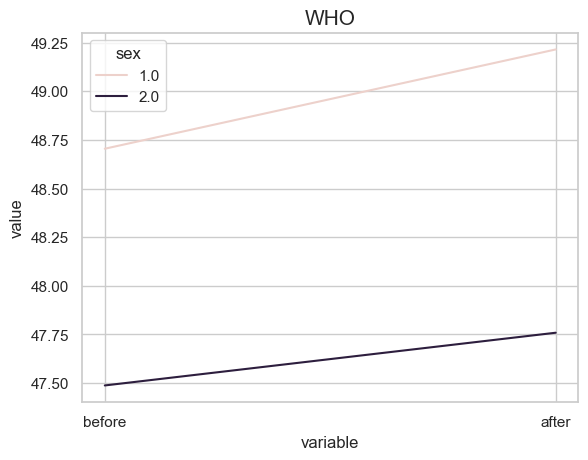

In [26]:
aggregated_who_df = pandas.melt(paired_plot_data_df[paired_plot_data_df["test"].str.contains('WHO')].groupby("Id")[["before", "after"]].sum(), value_vars=['before', 'after'], ignore_index=False).join(df_original[["Id", "sex", "age", "wyksztalcenie", "przynal_rel"]].set_index('Id'), on='Id', how='left', lsuffix='_caller', rsuffix='_other')

seaborn.set()
seaborn.set_style("whitegrid")

seaborn.lineplot(data=aggregated_who_df, x="variable", y="value", hue="sex", estimator="mean", errorbar=None)
plt.title("WHO", fontsize=15)
plt.show()

In [27]:
individuals_knowledge_data = {'time': ['before', 'after']}
individuals_who_data = {'time': ['before', 'after']} # no chain assigment since dict is mutable

ids = df_original['Id'].tolist()
for person_no in ids:
    individuals_who_data[person_no] = [sum(paired_plot_data_df[(paired_plot_data_df["Id"] == person_no) & paired_plot_data_df["test"].str.contains('WHO')]["before"].tolist()), sum(paired_plot_data_df[(paired_plot_data_df["Id"] == person_no) & paired_plot_data_df["test"].str.contains('WHO')]["after"].tolist())]

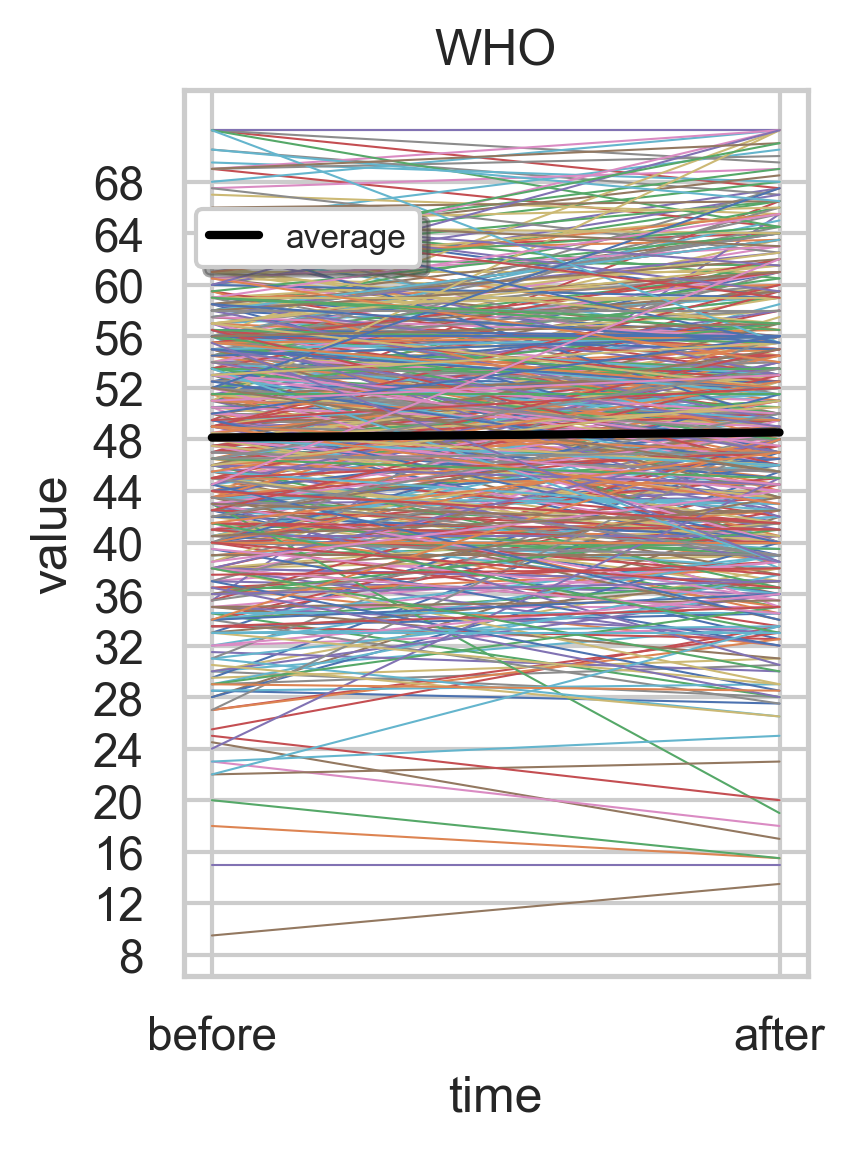

In [29]:
seaborn.set_style("whitegrid")
fig, axs = plt.subplots(figsize=(3, 4), dpi=300)

who_axes = seaborn.lineplot(x='time', y='value', hue='variable', legend=False, linewidth=0.5, data=pandas.melt(pandas.DataFrame(individuals_who_data), ['time']), palette="deep")
who_axes.set_title("WHO")
who_axes.set_yticks([n for n in range(0, 9*8, 4)])
who_axes.plot([0, 1], [sum(paired_plot_data_df[paired_plot_data_df["test"].str.contains('WHO')]["before"].tolist())/len(ids), sum(paired_plot_data_df[paired_plot_data_df["test"].str.contains('WHO')]["after"].tolist())/len(ids)], color="black", linewidth=2, label="average")
who_axes.legend(shadow=True, loc=(0.02, 0.8), handlelength=1.5, fontsize=8)

plt.tight_layout()
plt.show()

With computed paired sample t-test, Cohen's d values for effect size, and plotted the time changes with mean trajectories, let's work on visualising the questionaires' items relations with partial correlation networks. 

"In probability theory and statistics, partial correlation measures the degree of association between two random variables, with the effect of a set of controlling random variables removed. When determining the numerical relationship between two variables of interest, using their correlation coefficient will give misleading results if there is another confounding variable that is numerically related to both variables of interest. This misleading information can be avoided by controlling for the confounding variable, which is done by computing the partial correlation coefficient." - [Wikipedia](https://en.wikipedia.org/wiki/Partial_correlation) <br>
Partial correlation networks have also been called
concentration graphs (Cox & Wermuth, 1994) or Gaussian
graphical models (Lauritzen, 1996), and are part of a more
general class of statistical models termed pairwise Markov
random fields (see, e.g., Koller & Friedman, 2009 and Murphy,
2012 for an extensive description of pairwise Markov random
fields) - [Epskamp, 2018](https://eiko-fried.com/wp-content/uploads/Epskamp-Fried-2018-Tutorial-partial-corr.pdf)

In calculating the partial correlation, I'll use the inverse of a variance–covariance matrix described in _[Epskamp, S., & Fried, E. I. (2018). A tutorial on regularized partial correlation networks. Psychological Methods, 23(4), 617–634.](https://eiko-fried.com/wp-content/uploads/Epskamp-Fried-2018-Tutorial-partial-corr.pdf)_

In [30]:
selected_data = df_original[variable_list]
data_time_one = selected_data.filter(regex='^(?!.*_t).*$')
data_time_two = selected_data.filter(regex='.*_t.*')

cov_matrix_time_one = data_time_one.cov()
cov_matrix_time_two = data_time_two.cov()

# Moore–Penrose inverse
inverse_cov_matrix_time_one = pandas.DataFrame(numpy.linalg.pinv(cov_matrix_time_one.values), cov_matrix_time_one.columns, cov_matrix_time_one.index)
inverse_cov_matrix_time_two = pandas.DataFrame(numpy.linalg.pinv(cov_matrix_time_two.values), cov_matrix_time_two.columns, cov_matrix_time_two.index)

partial_corr_matrix_time_one = pandas.DataFrame(0, index=inverse_cov_matrix_time_one.index, columns=inverse_cov_matrix_time_one.columns)
for i in range(inverse_cov_matrix_time_one.shape[0]):
    for j in range(inverse_cov_matrix_time_one.shape[1]):
        if i != j:
            partial_corr_matrix_time_one.iloc[i, j] = -inverse_cov_matrix_time_one.iloc[i, j] / numpy.sqrt(inverse_cov_matrix_time_one.iloc[i, i] * inverse_cov_matrix_time_one.iloc[j, j])
        else:
            partial_corr_matrix_time_one.iloc[i, j] = 1.0

partial_corr_matrix_time_two = pandas.DataFrame(0, index=inverse_cov_matrix_time_two.index, columns=inverse_cov_matrix_time_two.columns)
for i in range(inverse_cov_matrix_time_two.shape[0]):
    for j in range(inverse_cov_matrix_time_two.shape[1]):
        if i != j:
            partial_corr_matrix_time_two.iloc[i, j] = -inverse_cov_matrix_time_two.iloc[i, j] / numpy.sqrt(inverse_cov_matrix_time_two.iloc[i, i] * inverse_cov_matrix_time_two.iloc[j, j])
        else:
            partial_corr_matrix_time_two.iloc[i, j] = 1.0

display(partial_corr_matrix_time_one.head())
display(partial_corr_matrix_time_two.head())


,WHO_zwiazki,WHO_zdr,WHO_wsparcie,WHO_sen,WHO_samooc_kol,WHO_samooc_ind,WHO_SPOL,WHO_FIZ
WHO_zwiazki,1.000000,0.095854,0.618619,-0.039602,0.078087,0.217118,-0.323077,0.070983
WHO_zdr,0.095854,1.000000,-0.012431,0.615691,0.003470,0.175642,0.087419,-0.521165
WHO_wsparcie,0.618619,-0.012431,1.000000,0.071169,0.146091,0.122624,-0.543695,0.062315
WHO_sen,-0.039602,0.615691,0.071169,1.000000,0.023399,0.197886,0.043421,-0.351636
WHO_samooc_kol,0.078087,0.003470,0.146091,0.023399,1.000000,0.144729,0.259382,0.029466


,WHO_zwiazki_t4,WHO_zdr_t4,WHO_wsparcie_t4,WHO_sen_t4,WHO_samooc_kol_t4,WHO_samooc_ind_t4,WHO_SPOL_t4,WHO_FIZ_t4
WHO_zwiazki_t4,1.000000,0.086435,0.655713,-0.063186,0.090294,0.116361,-0.296641,0.036461
WHO_zdr_t4,0.086435,1.000000,-0.061019,0.610569,0.051319,0.232459,0.020146,-0.548970
WHO_wsparcie_t4,0.655713,-0.061019,1.000000,0.125883,0.170617,0.197913,-0.526515,0.060038
WHO_sen_t4,-0.063186,0.610569,0.125883,1.000000,-0.008082,0.188737,0.088075,-0.326772
WHO_samooc_kol_t4,0.090294,0.051319,0.170617,-0.008082,1.000000,0.071342,0.317483,0.052713


With partial correlation matrixes computed for the time 1 and 2 measurements, let me:
1. calculate the p-values for the difference significance between times 1 & 2 of the measurements (to determine later on which edges are to be shown on the difference graphs);
1. plot the networks - communal narcissims with knowledga at times 1 and 2 
1. plot heatmaps of the partial correlations;
1. plot basic graphs' metric: nodal strength centrality
1. plot networks' bridge strength centrality 

In [31]:
p_value_diff_matrix = pandas.DataFrame(0, index=inverse_cov_matrix_time_one.index, columns=inverse_cov_matrix_time_one.columns)
n_count = df_original['Id'].count()
std_err = numpy.sqrt(1/(n_count - 3) + 1/(n_count - 3))

def fisher_z_transform(r):
    return 0.5 * numpy.log((1 + r) / (1 - r))

def calc_p_value(r1, r2):
    Z1 = fisher_z_transform(r1)
    Z2 = fisher_z_transform(r2)
    Z_diff = (Z1 - Z2) / std_err
    p_value = 2 * (1 - stats.norm.cdf(numpy.abs(Z_diff)))  # two-tailed test
    return p_value

for i in range(inverse_cov_matrix_time_one.shape[0]):
    for j in range(inverse_cov_matrix_time_one.shape[1]):
        if i != j:
            p_value_diff_matrix.iloc[i, j] = calc_p_value(partial_corr_matrix_time_one.iloc[i, j], partial_corr_matrix_time_two.iloc[i, j])
        else:
            p_value_diff_matrix.iloc[i, j] = 1.0

display(p_value_diff_matrix.head())

,WHO_zwiazki,WHO_zdr,WHO_wsparcie,WHO_sen,WHO_samooc_kol,WHO_samooc_ind,WHO_SPOL,WHO_FIZ
WHO_zwiazki,1.000000,0.875524,0.302711,0.696526,0.839321,0.087096,0.629564,0.567961
WHO_zdr,0.875524,1.000000,0.422212,0.892327,0.429585,0.328026,0.265652,0.520440
WHO_wsparcie,0.302711,0.422212,1.000000,0.362065,0.678203,0.202269,0.691315,0.969942
WHO_sen,0.696526,0.892327,0.362065,1.000000,0.603570,0.875442,0.459437,0.643061
WHO_samooc_kol,0.839321,0.429585,0.678203,0.603570,1.000000,0.220497,0.295742,0.700920


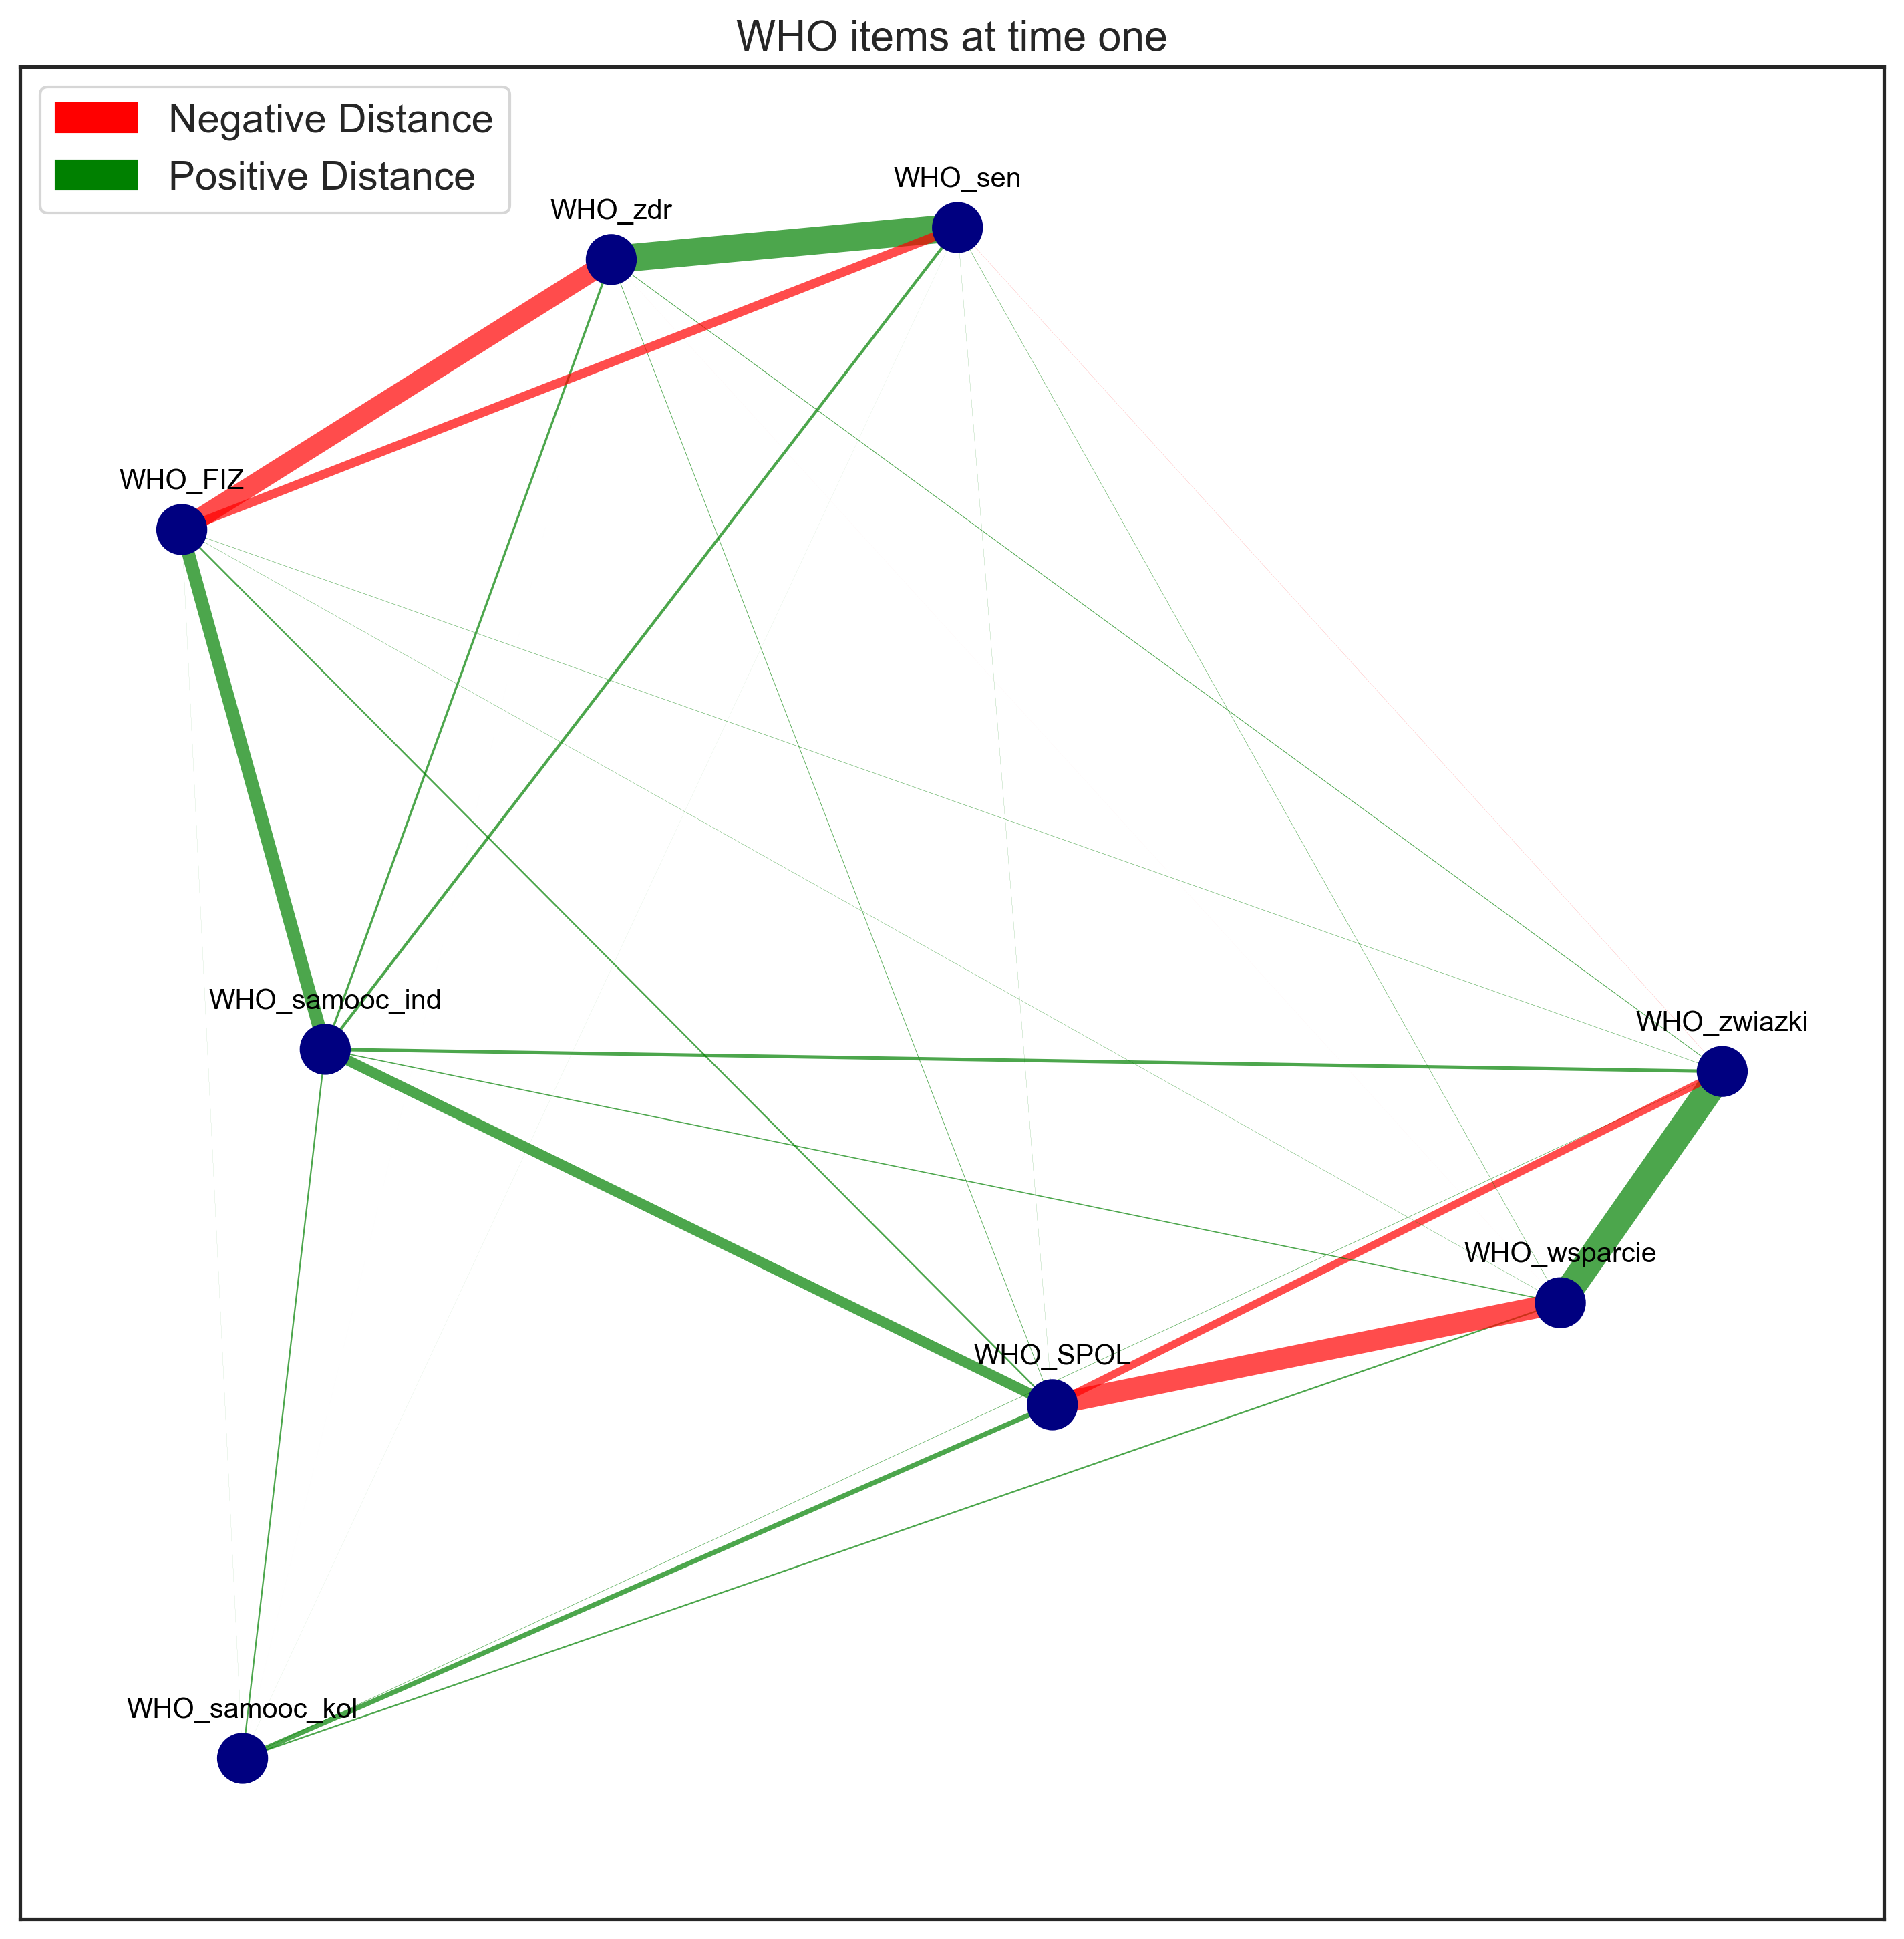

In [33]:
seaborn.set_style("white")

graph_WHO_time_one = networkx.from_pandas_adjacency(partial_corr_matrix_time_one)
graph_WHO_time_one.remove_edges_from(networkx.selfloop_edges(graph_WHO_time_one))

node_colors = ['navy' for node in graph_WHO_time_one.nodes]
edge_colors = ['red' if partial_corr_matrix_time_one.loc[edge[0], edge[1]] < 0 else 'green' for edge in graph_WHO_time_one.edges]
edge_width = [abs(partial_corr_matrix_time_one.loc[edge[0], edge[1]]) for edge in graph_WHO_time_one.edges]
edge_width_norm_t1 = [10 * (float(i)/max(edge_width))**2 for i in edge_width]

distances = {}
for n, nbrs in graph_WHO_time_one.adj.items():
    for nbr, eattr in nbrs.items():
        try:
            distances[n][nbr] = 0.25 + (1 - abs(eattr['weight']/max(edge_width)))
        except KeyError as e:
            distances[n] = {nbr: 0.25 + (1 - abs(eattr['weight']/max(edge_width)))}
        
node_pos_WHO = networkx.kamada_kawai_layout(graph_WHO_time_one, dist=distances, weight='weight')
pos_higher = {}
y_off = 0.06
for k, v in node_pos_WHO.items():
    pos_higher[k] = (v[0], v[1]+y_off)

plt.figure(figsize=(12, 12), dpi=300)
networkx.draw_networkx_edges(graph_WHO_time_one, node_pos_WHO, edge_color=edge_colors, width=edge_width_norm_t1, alpha=0.7)
networkx.draw_networkx_nodes(graph_WHO_time_one, node_pos_WHO, node_color=node_colors, node_size=300)
networkx.draw_networkx_labels(graph_WHO_time_one, pos_higher, font_size=10, font_color='black')

blue_patch = mpatches.Patch(color='red', label='Negative Distance')
red_patch = mpatches.Patch(color='green', label='Positive Distance')
plt.legend(handles=[blue_patch, red_patch], loc='upper left', fontsize='large')

plt.title("WHO items at time one", fontsize=15)
plt.show()

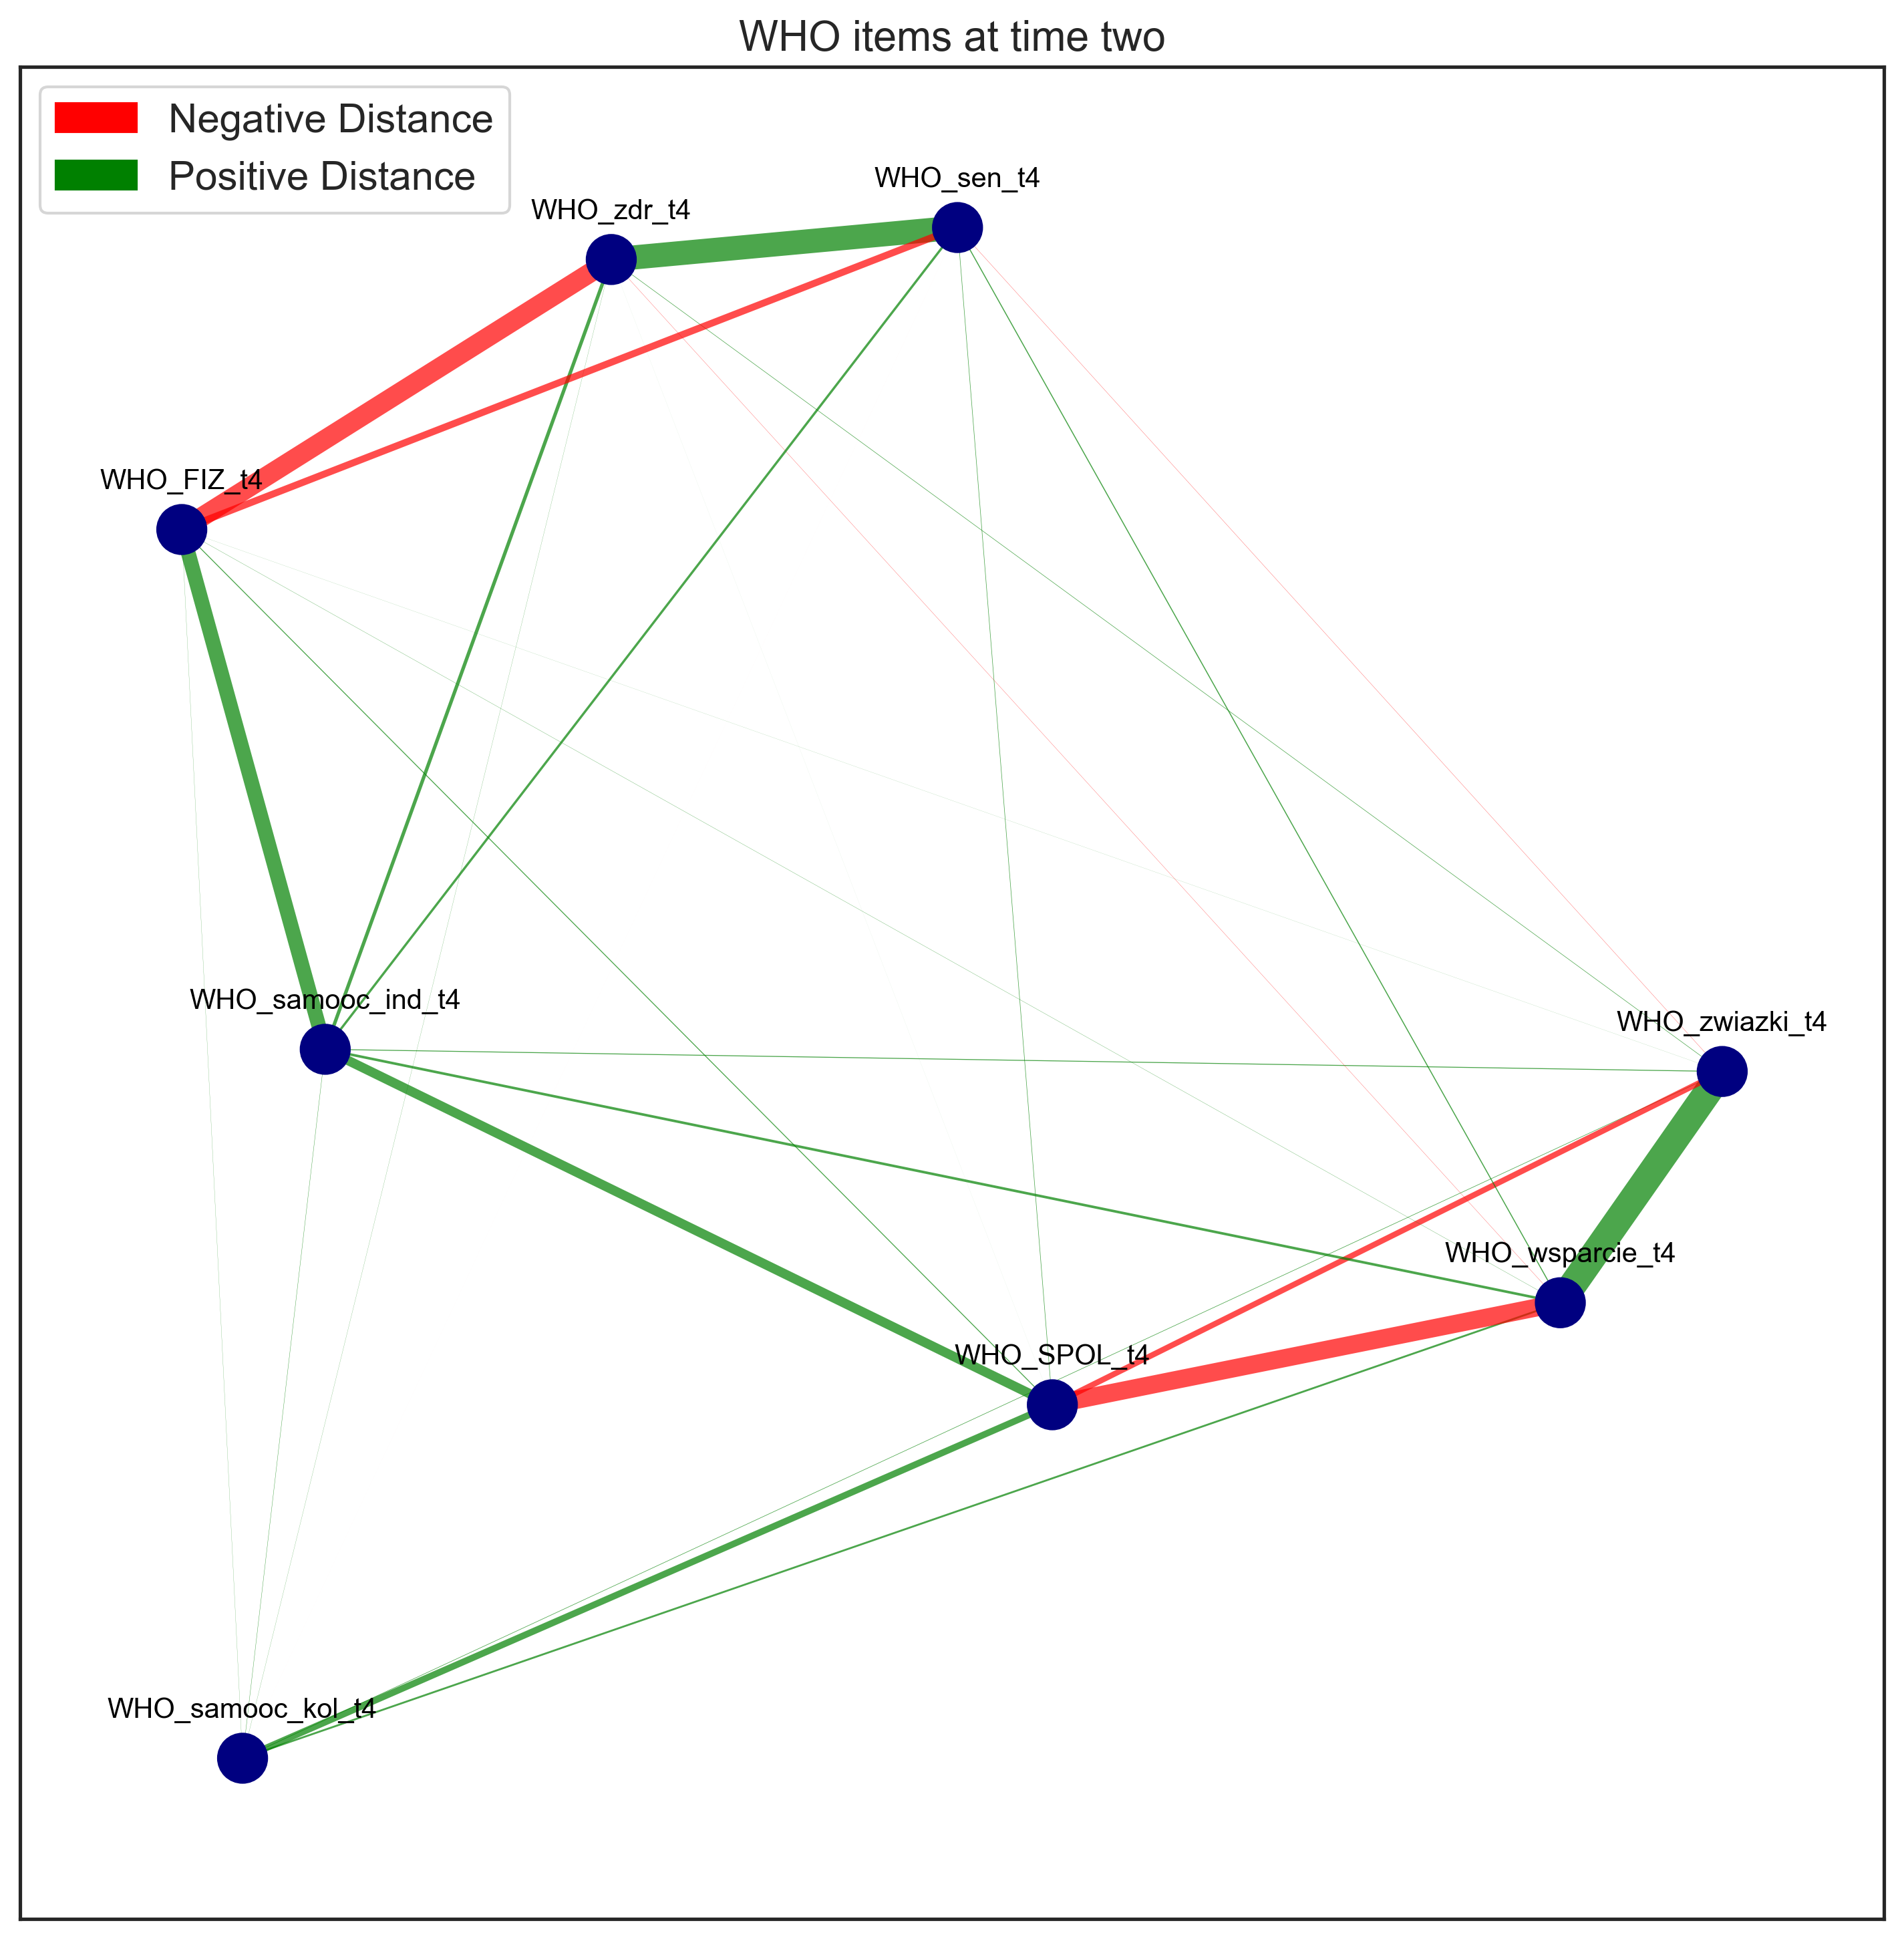

In [36]:
seaborn.set_style("white")

graph_WHO_time_two = networkx.from_pandas_adjacency(partial_corr_matrix_time_two)
graph_WHO_time_two.remove_edges_from(networkx.selfloop_edges(graph_WHO_time_two))

node_pos_WHO_t4 = {f"{node}_t4": pos for (node, pos) in node_pos_WHO.items()}
pos_higher = {}
y_off = 0.06
for k, v in node_pos_WHO_t4.items():
    pos_higher[k] = (v[0], v[1]+y_off)

node_colors = ['navy' for node in graph_WHO_time_two.nodes]
edge_colors = ['red' if partial_corr_matrix_time_two.loc[edge[0], edge[1]] < 0 else 'green' for edge in graph_WHO_time_two.edges]
edge_width = [abs(partial_corr_matrix_time_two.loc[edge[0], edge[1]]) for edge in graph_WHO_time_two.edges]
edge_width_norm_t2 = [10 * (float(i)/max(edge_width))**2 for i in edge_width]
    
plt.figure(figsize=(12, 12), dpi=300)
networkx.draw_networkx_edges(graph_WHO_time_two, node_pos_WHO_t4, edge_color=edge_colors, width=edge_width_norm_t2, alpha=0.7)
networkx.draw_networkx_nodes(graph_WHO_time_two, node_pos_WHO_t4, node_color=node_colors, node_size=300)
networkx.draw_networkx_labels(graph_WHO_time_two, pos_higher, font_size=10, font_color='black')

blue_patch = mpatches.Patch(color='red', label='Negative Distance')
red_patch = mpatches.Patch(color='green', label='Positive Distance')
plt.legend(handles=[blue_patch, red_patch], loc='upper left', fontsize='large')

plt.title("WHO items at time two", fontsize=15)
plt.show()

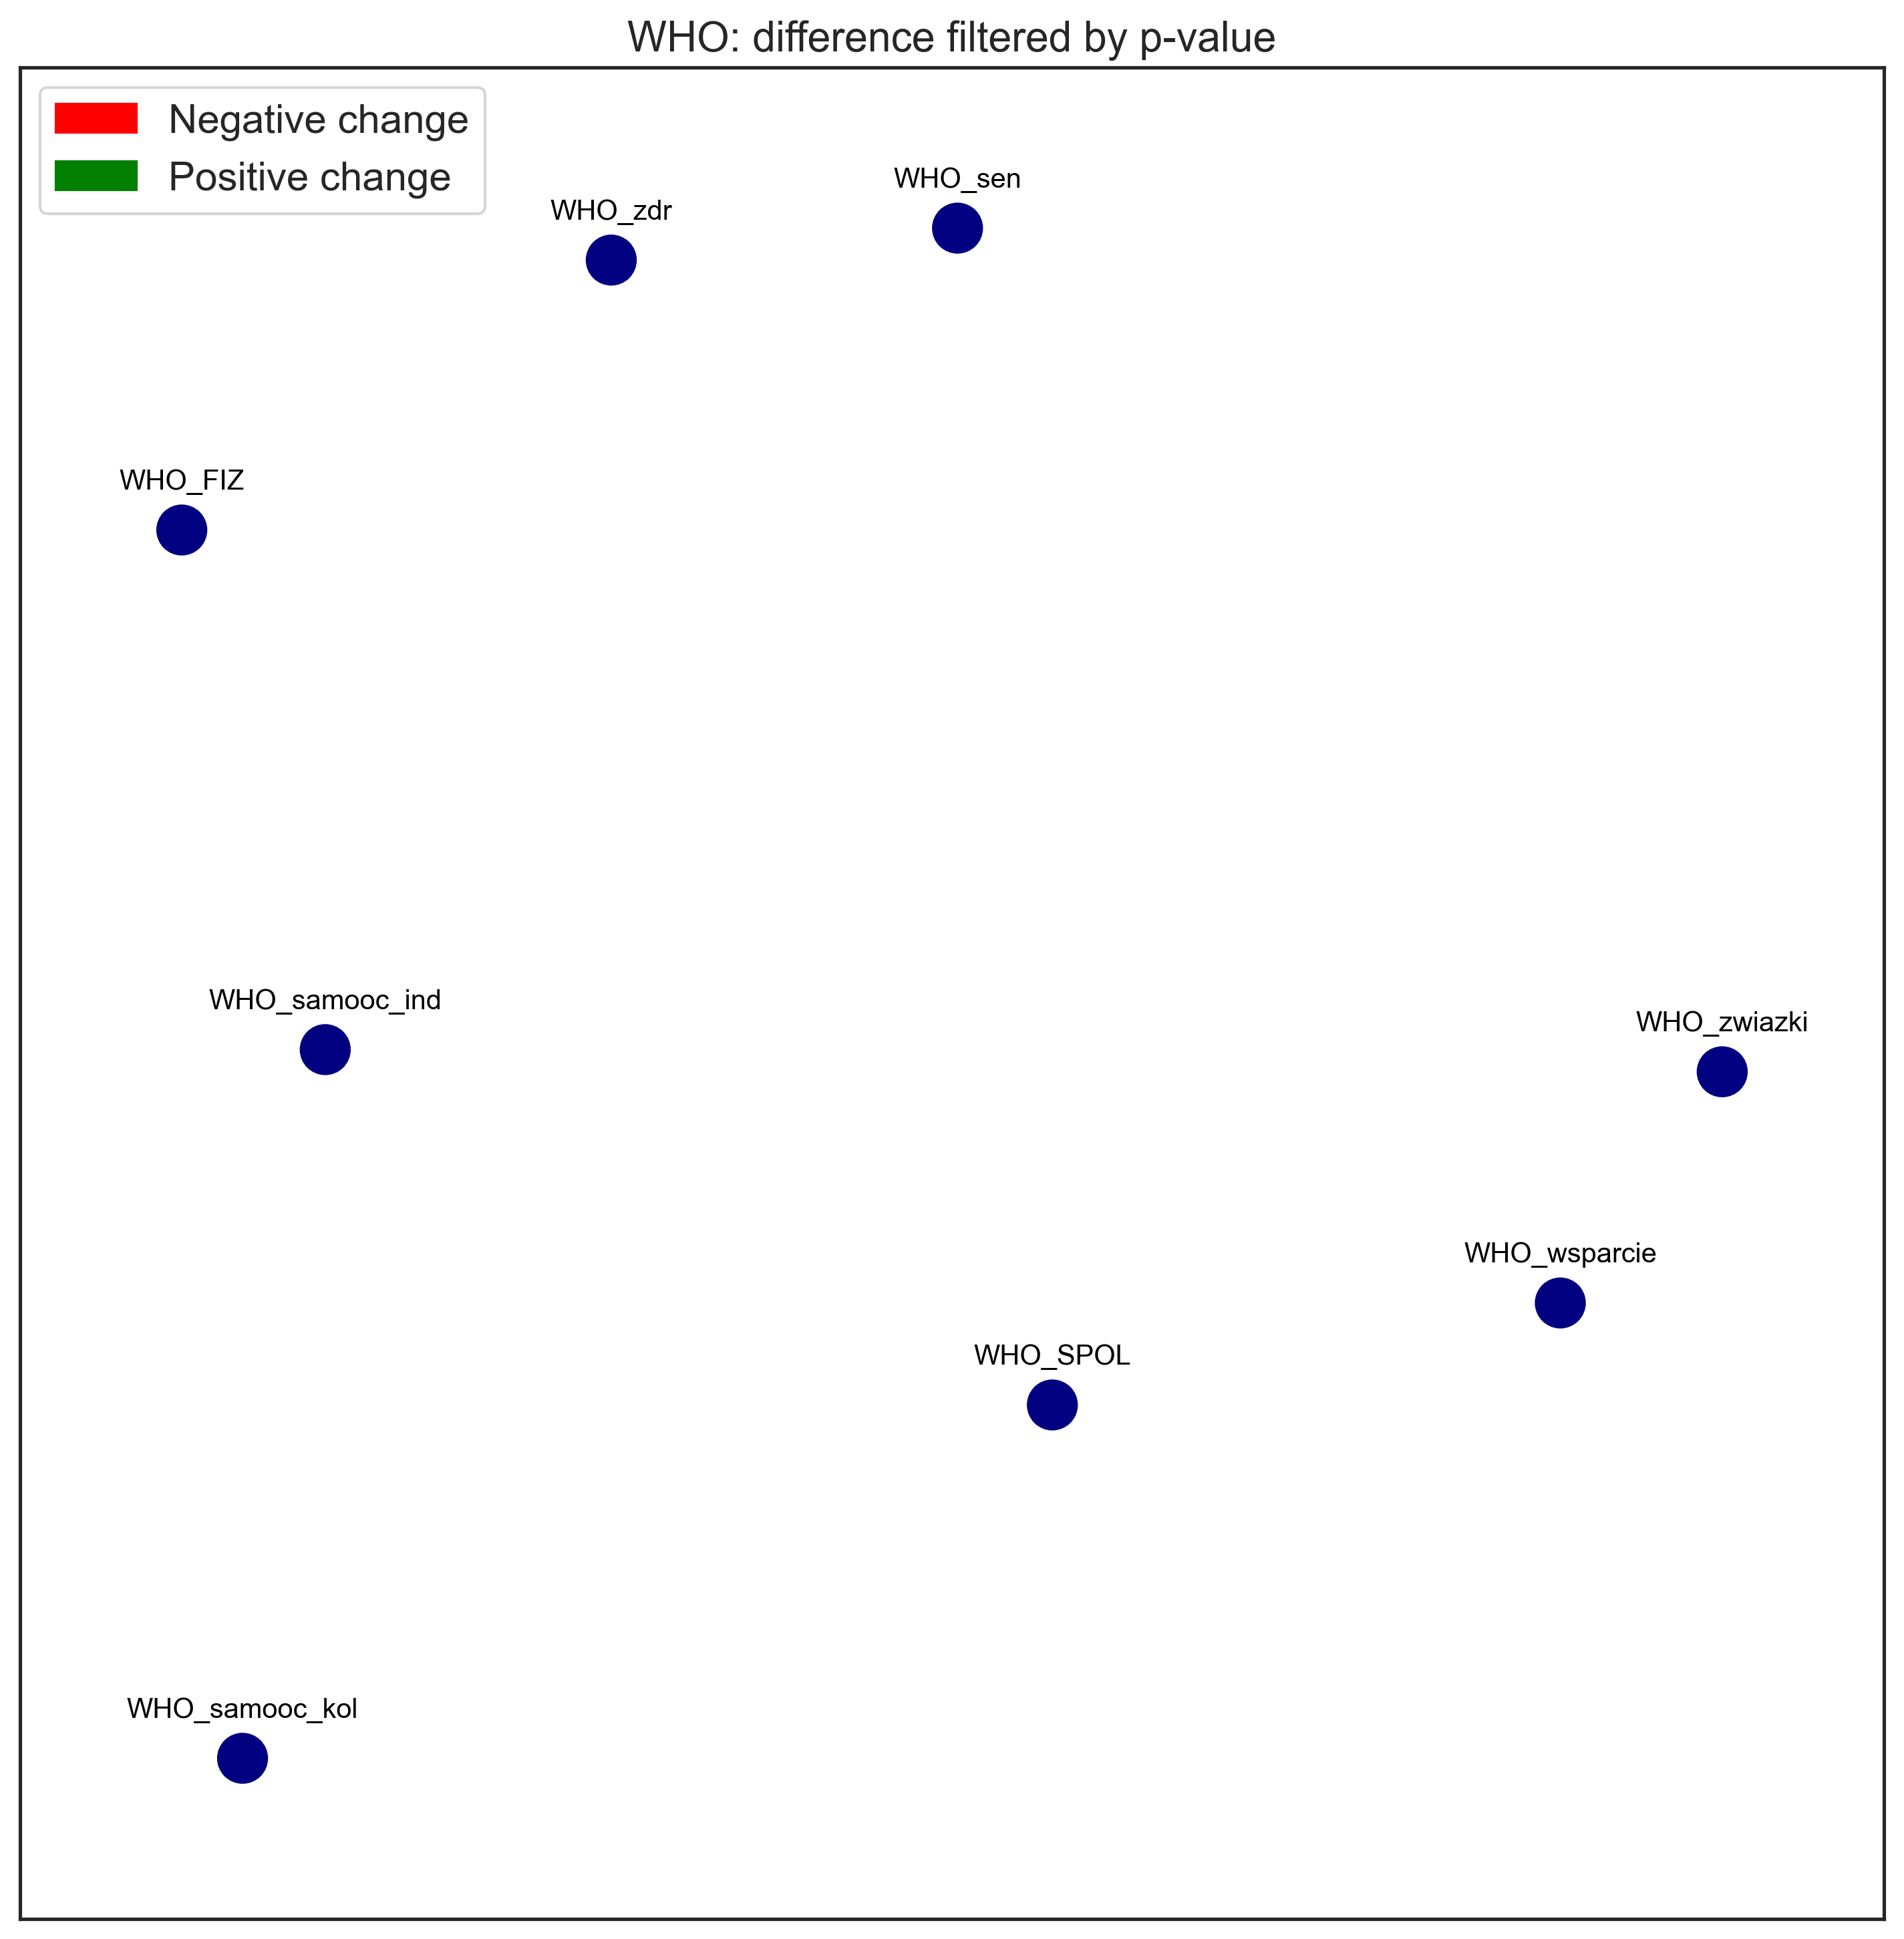

In the above graph there are 0 non-zero edges.


In [50]:
seaborn.set_style("white")

graph_WHO_diff = networkx.from_pandas_adjacency(partial_corr_matrix_time_one)
graph_WHO_diff.remove_edges_from(networkx.selfloop_edges(graph_WHO_diff))

node_pos_WHO_diff = {f"{node}": pos for (node, pos) in node_pos_WHO.items()}
pos_higher = {}
y_off = 0.06
for k, v in node_pos_WHO_diff.items():
    pos_higher[k] = (v[0], v[1]+y_off)

node_colors = ['navy' for node in graph_WHO_diff.nodes]
edge_colors = ['red' if partial_corr_matrix_time_one.loc[edge_one[0], edge_one[1]] > partial_corr_matrix_time_two.loc[edge_two[0], edge_two[1]] else 'green' for (edge_one, edge_two) in zip(graph_WHO_time_one.edges, graph_WHO_time_two.edges)]
edge_width = [abs(partial_corr_matrix_time_two.loc[edge_two[0], edge_two[1]] - partial_corr_matrix_time_one.loc[edge_one[0], edge_one[1]]) if p_value_diff_matrix.loc[edge_one[0], edge_one[1]] < 0.05 else 0 for (edge_one, edge_two) in zip(graph_WHO_time_one.edges, graph_WHO_time_two.edges)]
if max(edge_width) != 0:
    edge_width = [10 * (float(i)/max(edge_width))**2 for i in edge_width]

plt.figure(figsize=(12, 12), dpi=300)
networkx.draw_networkx_edges(graph_WHO_diff, node_pos_WHO_diff, edge_color=edge_colors, width=edge_width, alpha=0.7)
networkx.draw_networkx_nodes(graph_WHO_diff, node_pos_WHO_diff, node_color=node_colors, node_size=300)
networkx.draw_networkx_labels(graph_WHO_diff, pos_higher, font_size=10, font_color='black')

blue_patch = mpatches.Patch(color='red', label='Negative change')
red_patch = mpatches.Patch(color='green', label='Positive change')
plt.legend(handles=[blue_patch, red_patch], loc='upper left', fontsize='large')

plt.title("WHO: difference filtered by p-value", fontsize=15)
plt.show()

print(f"In the above graph there are {sum(1 for i in edge_width if i != 0)} non-zero edges.")

There are no edges on the above graph's chart, since the only significant changes observed from time 1 to time 1 were changes for 'WHO_FIZ' and 'WHO_zdr' - self looped edges for those two nodes in the graph of the significant differences.

<b>_I'm not adding heatmaps for the average edge values between questionnaires (within group and between groups) as those have no meaning when only one items group is considered_</b>

In [56]:
graph_time_one_sorted = sorted(graph_WHO_time_one.edges(data=True), key= lambda x: x[2]['weight'], reverse=True)
graph_time_two_sorted = sorted(graph_WHO_time_two.edges(data=True), key= lambda x: x[2]['weight'], reverse=True)

strongest_edges_data = {'time 1 edge': [],
                       'time 1 weight': [],
                       'time 2 edge': [],
                       'time 2 weight': []}
for i in range(0, 10):
    strongest_edges_data['time 1 edge'].append(f"{graph_time_one_sorted[i][0]} ↔ {graph_time_one_sorted[i][1]}")
    strongest_edges_data['time 1 weight'].append(graph_time_one_sorted[i][2]['weight'])
    strongest_edges_data['time 2 edge'].append(f"{graph_time_two_sorted[i][0]} ↔ {graph_time_two_sorted[i][1]}")
    strongest_edges_data['time 2 weight'].append(graph_time_two_sorted[i][2]['weight'])

strongest_edges_df = pandas.DataFrame(strongest_edges_data)
display(strongest_edges_df)

,time 1 edge,time 1 weight,time 2 edge,time 2 weight
0,WHO_zwiazki ↔ WHO_wsparcie,0.618619,WHO_zwiazki_t4 ↔ WHO_wsparcie_t4,0.655713
1,WHO_zdr ↔ WHO_sen,0.615691,WHO_zdr_t4 ↔ WHO_sen_t4,0.610569
2,WHO_samooc_ind ↔ WHO_FIZ,0.422991,WHO_samooc_ind_t4 ↔ WHO_FIZ_t4,0.476604
3,WHO_samooc_ind ↔ WHO_SPOL,0.379629,WHO_samooc_ind_t4 ↔ WHO_SPOL_t4,0.381359
4,WHO_samooc_kol ↔ WHO_SPOL,0.259382,WHO_samooc_kol_t4 ↔ WHO_SPOL_t4,0.317483
5,WHO_zwiazki ↔ WHO_samooc_ind,0.217118,WHO_zdr_t4 ↔ WHO_samooc_ind_t4,0.232459
6,WHO_sen ↔ WHO_samooc_ind,0.197886,WHO_wsparcie_t4 ↔ WHO_samooc_ind_t4,0.197913
7,WHO_zdr ↔ WHO_samooc_ind,0.175642,WHO_sen_t4 ↔ WHO_samooc_ind_t4,0.188737
8,WHO_SPOL ↔ WHO_FIZ,0.150883,WHO_wsparcie_t4 ↔ WHO_samooc_kol_t4,0.170617
9,WHO_wsparcie ↔ WHO_samooc_kol,0.146091,WHO_wsparcie_t4 ↔ WHO_sen_t4,0.125883


Text(0.5, 1.0, 'Edge values heatmap at time one')

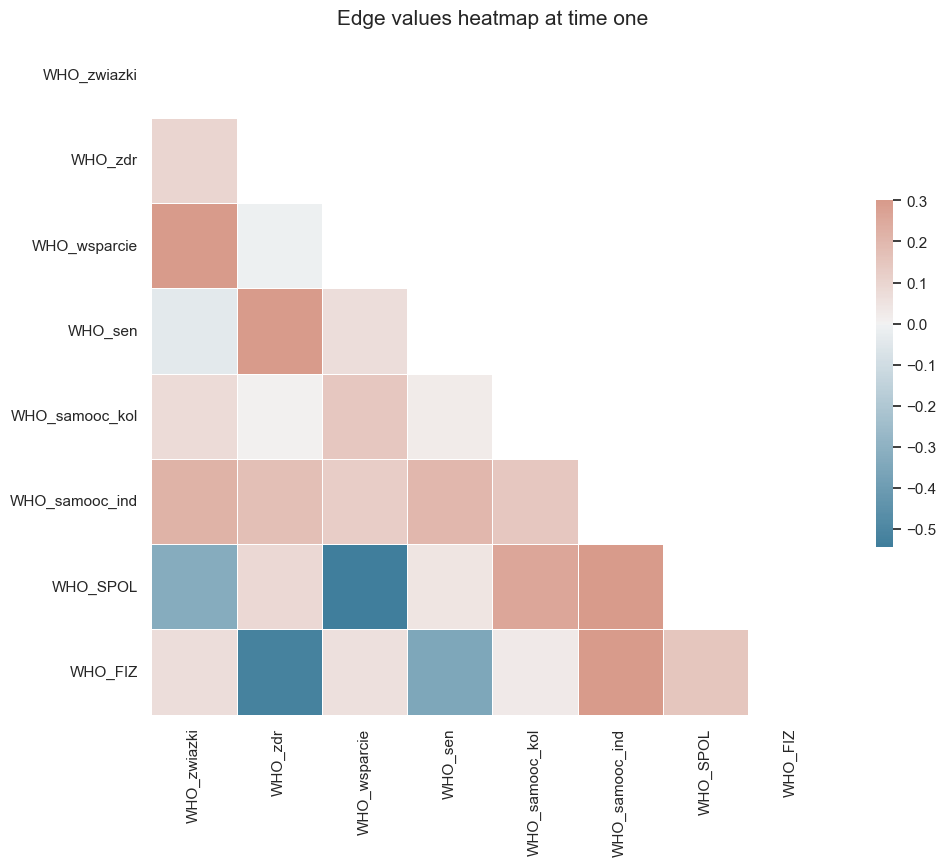

In [57]:
mask = numpy.triu(numpy.ones_like(partial_corr_matrix_time_one, dtype=bool))

fig, ax = plt.subplots(figsize=(11, 9))

cmap = seaborn.diverging_palette(230, 20, as_cmap=True)

seaborn.heatmap(partial_corr_matrix_time_one, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Edge values heatmap at time one", fontsize=15)

Text(0.5, 1.0, 'Edge values heatmap at time two')

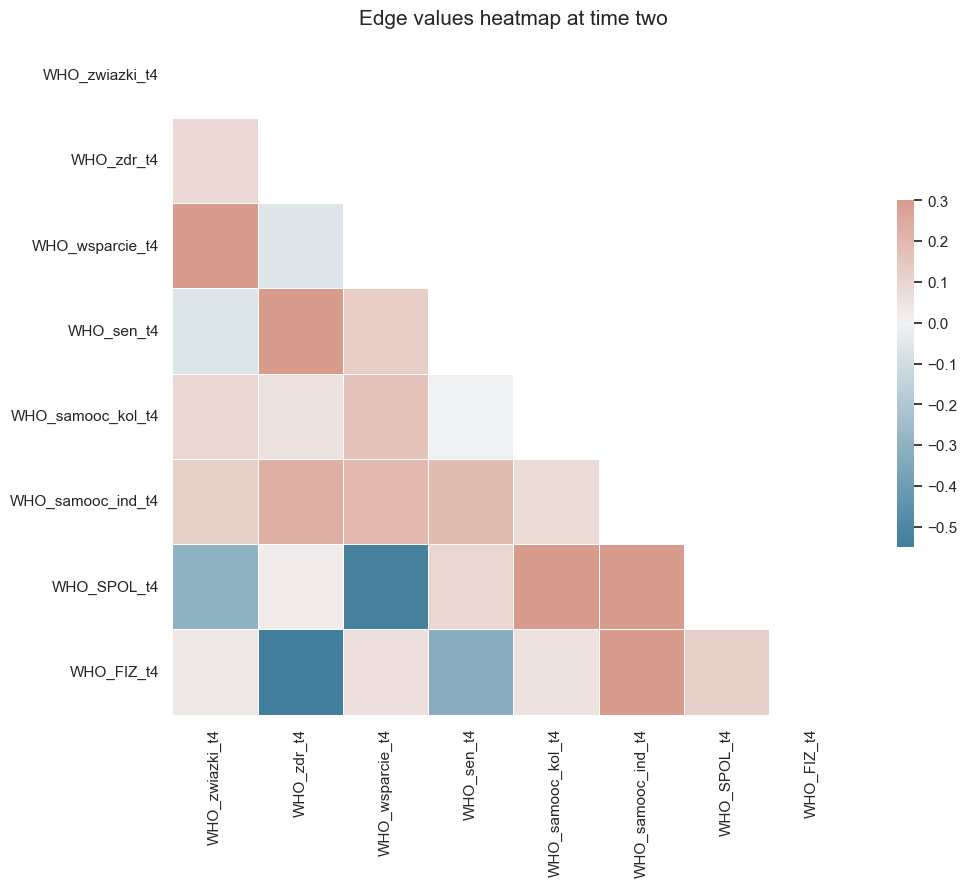

In [58]:
mask = numpy.triu(numpy.ones_like(partial_corr_matrix_time_two, dtype=bool))

fig, ax = plt.subplots(figsize=(11, 9))

cmap = seaborn.diverging_palette(230, 20, as_cmap=True)

seaborn.heatmap(partial_corr_matrix_time_two, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Edge values heatmap at time two", fontsize=15)

Now, let me calculate the nodal strength centrality, as defined in [Yu, J., Mahendran, R. COVID-19 lockdown has altered the dynamics between affective symptoms and social isolation among older adults: results from a longitudinal network analysis. Sci Rep 11, 14739 (2021)](https://www.nature.com/articles/s41598-021-94301-6): _"Global strength refers to the sum of the absolute values of all edges in the network. The edge value represents the partial correlation between a pair of nodes after controlling for the influence of other nodes. The nodal strength centrality is the sum of these absolute values from all edges that connect to the node."_

In [59]:
nodal_strength_centrality_time_one = {}
for column in partial_corr_matrix_time_one.columns:
    nodal_strength_centrality_time_one[column] = partial_corr_matrix_time_one[column].abs().sum() - 1 # -1 for variance
    
nodal_strength_centrality_time_two = {}
for column in partial_corr_matrix_time_two.columns:
    nodal_strength_centrality_time_two[column[:-3]] = partial_corr_matrix_time_two[column].abs().sum() - 1 # -1 for variance

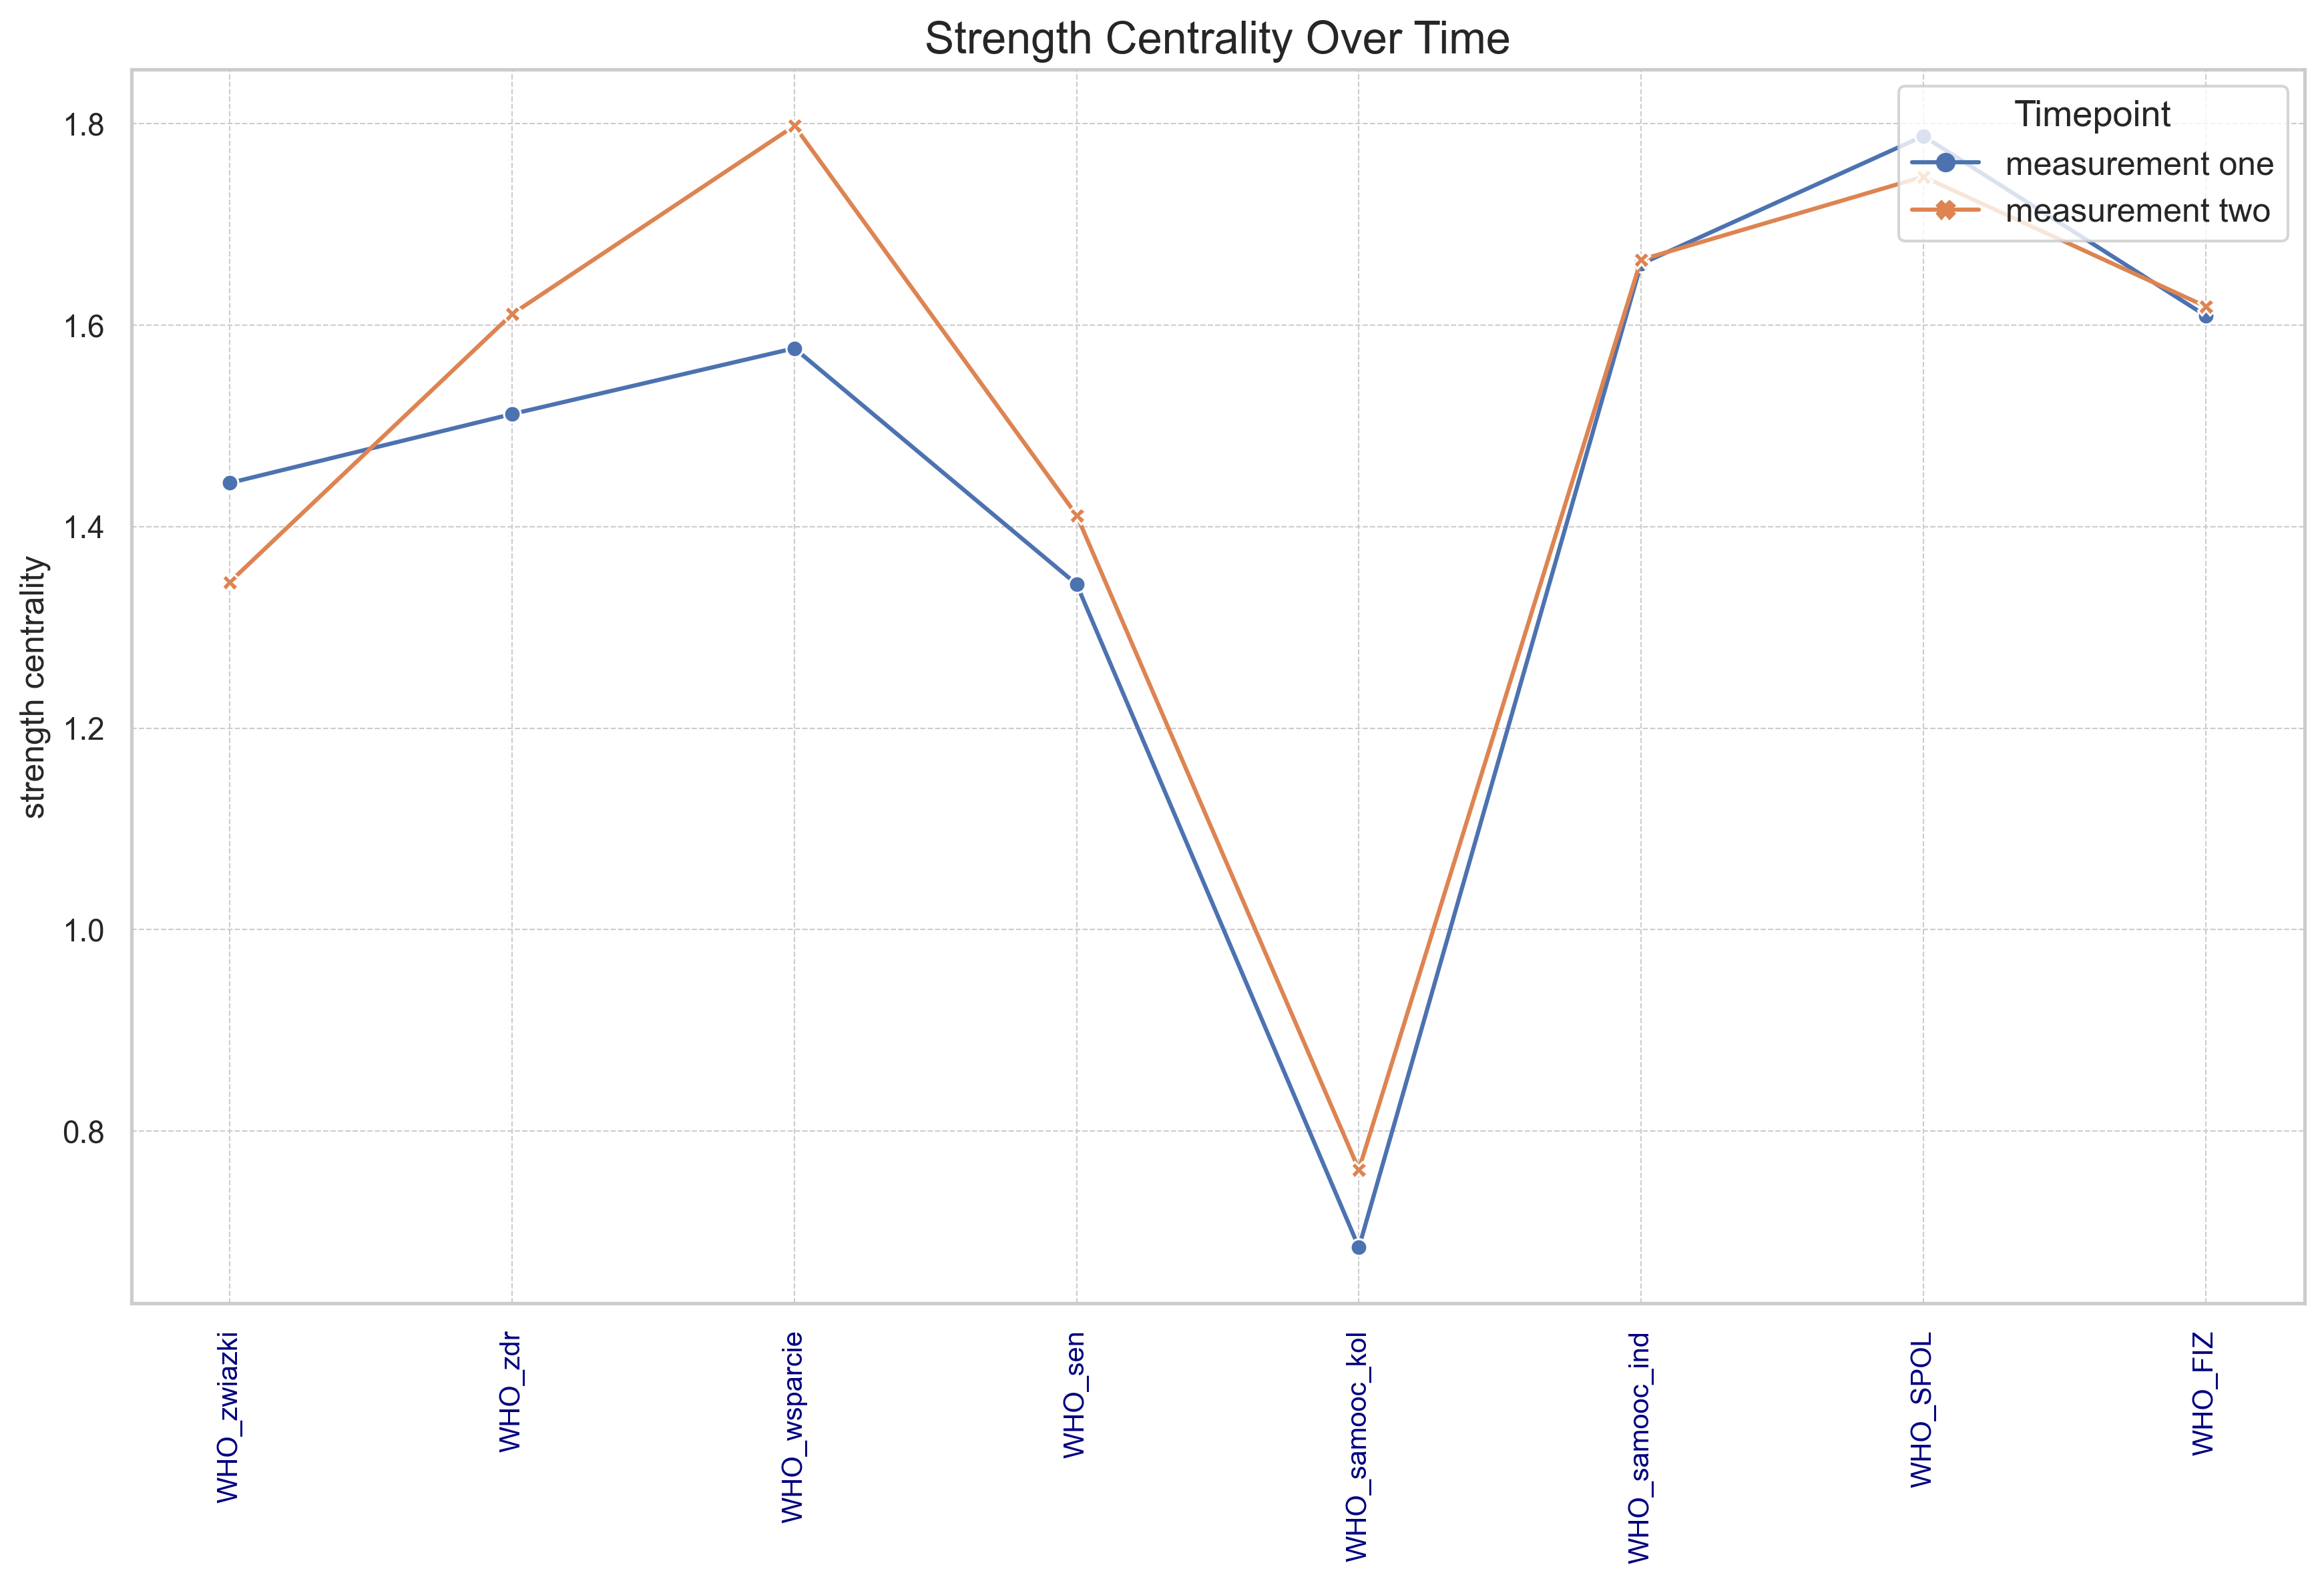

In [60]:
seaborn.set(style="whitegrid")

data_time_one = {
    'variable': nodal_strength_centrality_time_one.keys(),
    'strength centrality': nodal_strength_centrality_time_one.values(),
    'timepoint': ['measurement one' for variable in nodal_strength_centrality_time_one.keys()]
}
data_time_two = {
    'variable': nodal_strength_centrality_time_two.keys(),
    'strength centrality': nodal_strength_centrality_time_two.values(),
    'timepoint': ['measurement two' for variable in nodal_strength_centrality_time_two.keys()]
}
data_time_one = pandas.DataFrame(data_time_one)
data_time_two = pandas.DataFrame(data_time_two)
data = pandas.concat([data_time_one, data_time_two])

plt.figure(figsize=(14, 8), dpi=300)
seaborn.lineplot(x='variable', y='strength centrality', hue='timepoint', style='timepoint', data=data, markers=True, dashes=False)

plt.xticks(rotation=90, fontsize=10)
plt.xlabel('')

plt.legend(title='Timepoint', fontsize=12, title_fontsize='13', loc='upper right')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().set_axisbelow(True)

for tick_label in plt.gca().get_xticklabels():
    if 'WHO' in tick_label.get_text():
        tick_label.set_color('navy')
    else:
        tick_label.set_color('red')

plt.title('Strength Centrality Over Time', fontsize=16)

plt.show()

<b>_I'm not adding a lineplot for the Bridge Centrality Over Time as there are no bridges, since there's only one item group._</b>